# モンテカルロ法によるリスク評価

### 評価前提
- 東京エリア
- FY2023の結果をもとにモデルを作る

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# matplotlib の日本語フォント設定
plt.rcParams['font.family'] = 'Noto Sans CJK JP'

In [12]:
import matplotlib.font_manager as fm
fm.findSystemFonts()

['/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc',
 '/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc',
 '/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc',
 '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc']

### データ準備
- 需要: 東京電力エリア需要
- 電力価格: JEPX東京エリアプライス
  - 2024/1までは1時間値 [万kW]、それ以降は30分値 [MW] が公開されている → 1時間値を30分値に補完し、単位をMWに統一

In [13]:
df = pd.read_csv('tso/tokyo/area-2023.csv', encoding='shift-jis', skiprows=2)
df.index = pd.date_range('2023-04-01', periods=len(df), freq='h')
df_30min = pd.DataFrame(index=pd.date_range('2023-04-01', periods=len(df)*2, freq='30min'))
df_30min["エリア需要"] = df.iloc[:, 2] * 10 # 万kW -> MW
df_30min["太陽光発電実績"] = df.iloc[:, 8] * 10 # 万kW -> MW
df_30min.interpolate(method='linear', inplace=True)

In [14]:
df_2 = pd.read_csv('tso/tokyo/eria_jukyu_202402_03.csv', skiprows=1)
df_2.index = pd.date_range('2024-02-01', periods=len(df_2), freq='30min')
df_3 = pd.read_csv('tso/tokyo/eria_jukyu_202403_03.csv', skiprows=1)
df_3.index = pd.date_range('2024-03-01', periods=len(df_3), freq='30min')

In [15]:
# df_30min, df_2, df_3 を縦に結合
df_all = pd.concat([df_30min, df_2[["エリア需要", "太陽光発電実績"]], df_3[["エリア需要", "太陽光発電実績"]]])

In [16]:
# JEPX
df_spot_2023 = pd.read_csv("jepx/spot_summary_2023.csv", encoding="shift-jis", parse_dates=["受渡日"])
df_spot_2023.index = pd.date_range('2023-04-01', periods=len(df_spot_2023), freq='30min')

In [17]:
df_spot_price_col = "エリアプライス東京(円/kWh)"

In [18]:
df_all["price"] = df_spot_2023[df_spot_price_col]

<Axes: xlabel='エリア需要', ylabel='price'>

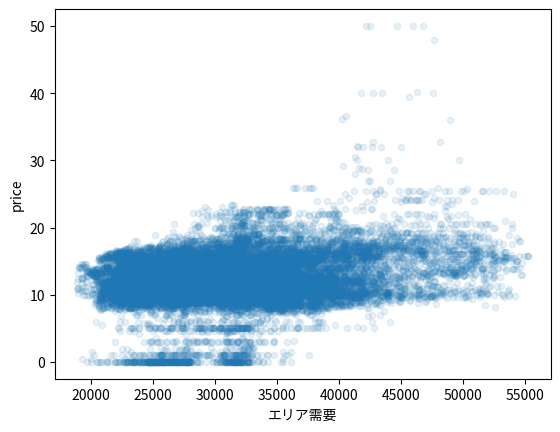

In [19]:
# エリア需要とpriceの相関を見る
df_all.corr()
# プロットする
df_all.plot.scatter(x="エリア需要", y="price", alpha=0.1)

In [20]:
# fuel_price
df_lng_cif = pd.read_csv("fuel_price/lng_cif.csv")
df_lng_cif.head()

,year,month,price(kJPY_MT)
0,2001,1,29.023668
1,2001,2,28.846437
2,2001,3,29.637337
3,2001,4,30.267330
4,2001,5,29.482429


In [21]:
# FY2023
df_lng_cif_2023 = df_lng_cif.iloc[12*22+3:12*23+4]
df_lng_cif_2023.index = pd.date_range('2023-04-01', periods=13, freq='MS')

In [22]:
df_lng_cif_2023["price(kJPY_MT)"].resample("30min").ffill() #30minにリサンプリング

2023-04-01 00:00:00    93.159577
2023-04-01 00:30:00    93.159577
2023-04-01 01:00:00    93.159577
2023-04-01 01:30:00    93.159577
2023-04-01 02:00:00    93.159577
                         ...    
2024-03-31 22:00:00    95.969438
2024-03-31 22:30:00    95.969438
2024-03-31 23:00:00    95.969438
2024-03-31 23:30:00    95.969438
2024-04-01 00:00:00    88.724801
Freq: 30min, Name: price(kJPY_MT), Length: 17569, dtype: float64

In [23]:
df_all["LNG_CIF"] = df_lng_cif_2023["price(kJPY_MT)"].resample("30min").ffill()

In [24]:
df_all

,エリア需要,太陽光発電実績,price,LNG_CIF
2023-04-01 00:00:00,23380.0,0.0,14.68,93.159577
2023-04-01 00:30:00,22920.0,0.0,13.99,93.159577
2023-04-01 01:00:00,22460.0,0.0,11.83,93.159577
2023-04-01 01:30:00,22435.0,0.0,11.08,93.159577
2023-04-01 02:00:00,22410.0,0.0,11.02,93.159577
...,...,...,...,...
2024-03-31 21:30:00,24806.0,0.0,12.35,95.969438
2024-03-31 22:00:00,24204.0,0.0,12.09,95.969438
2024-03-31 22:30:00,23387.0,0.0,9.50,95.969438
2024-03-31 23:00:00,23056.0,0.0,9.48,95.969438


In [40]:
# ごく単純に、priceをエリア需要とLNG_CIFで重回帰
X = df_all[["エリア需要", "太陽光発電実績", "LNG_CIF"]]
y = df_all["price"]

model = sm.OLS(y, sm.add_constant(X))
result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     4532.
Date:                Fri, 11 Oct 2024   Prob (F-statistic):               0.00
Time:                        17:46:34   Log-Likelihood:                -44612.
No. Observations:               17568   AIC:                         8.923e+04
Df Residuals:                   17564   BIC:                         8.926e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.1901      0.435     44.138      0.000      18.338      20.042
エリア需要          0.0003   3.56e-06     83.798      0.000       0.000       0.000
太陽光発電実績       -0.0006    5.8e-06   -103.410      0.000      -0.001      -0.001
LNG_CIF       -0.1580      0.005    -34.325      0.000      -0.167      -0.149
==============================================================================
Omnibus:                     3801.784   Durbin-Watson:                   0.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21873.650
Skew:                           0.919   Prob(JB):                         0.00
Kurtosis:                       8.148   Cond. No.                     6.15e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
# 予測
df_all["price_from_model"] = result.predict(sm.add_constant(X))

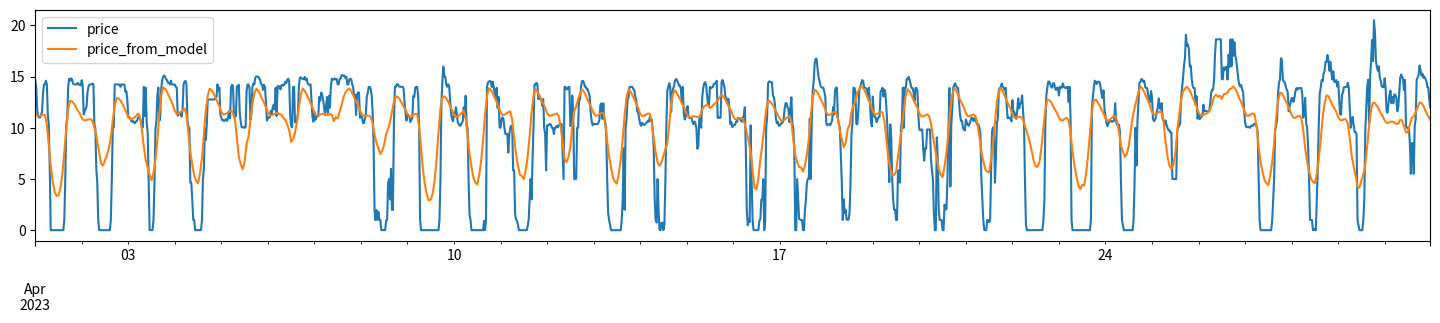

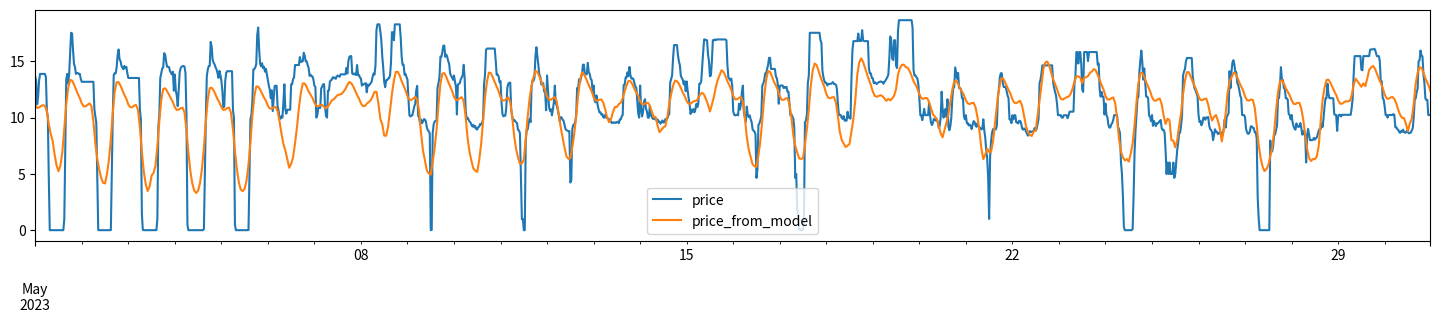

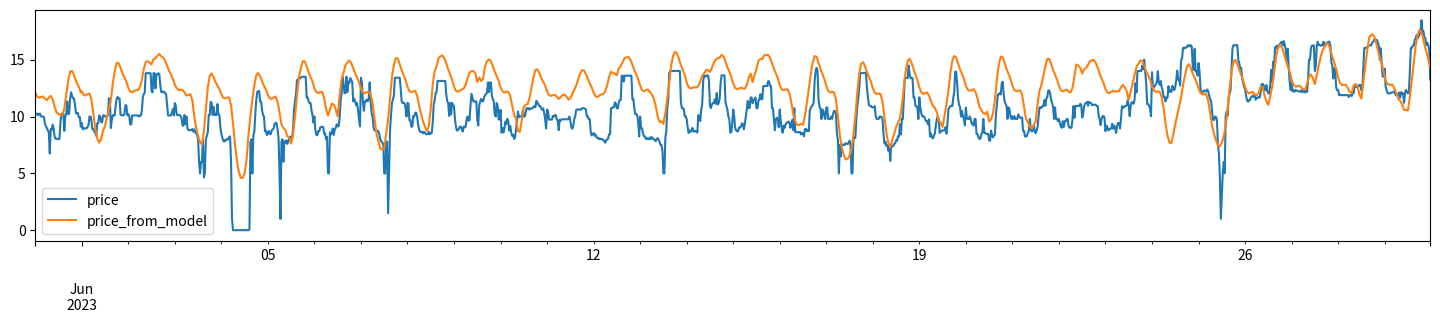

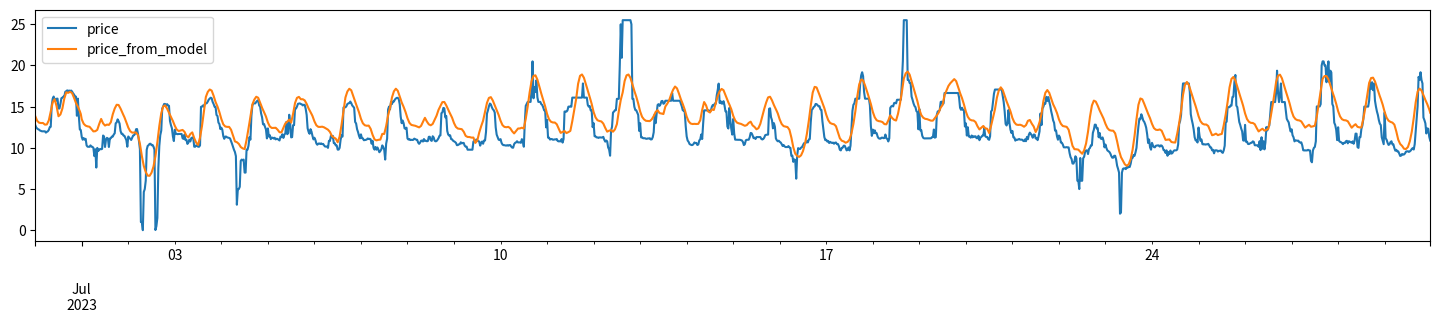

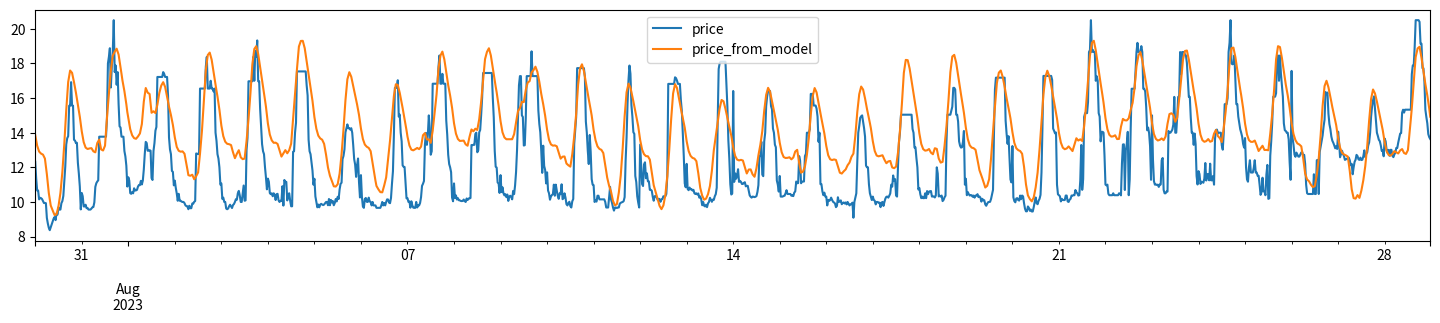

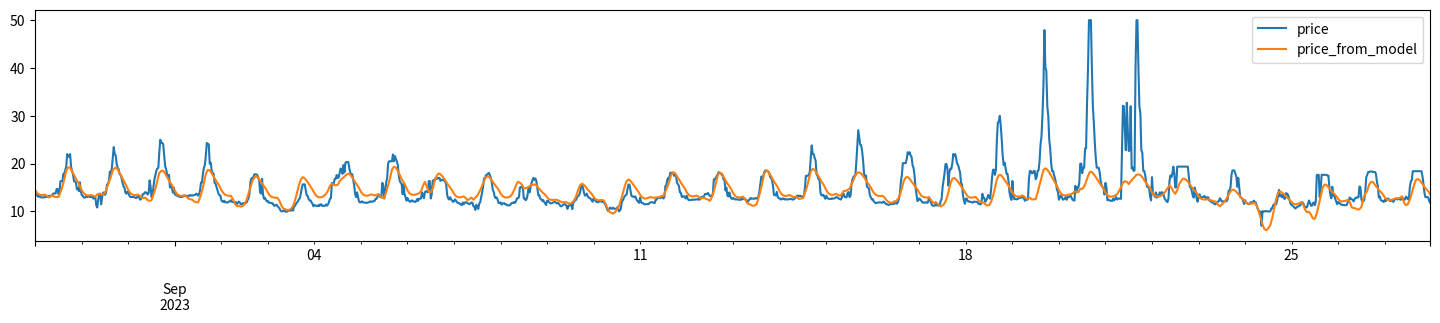

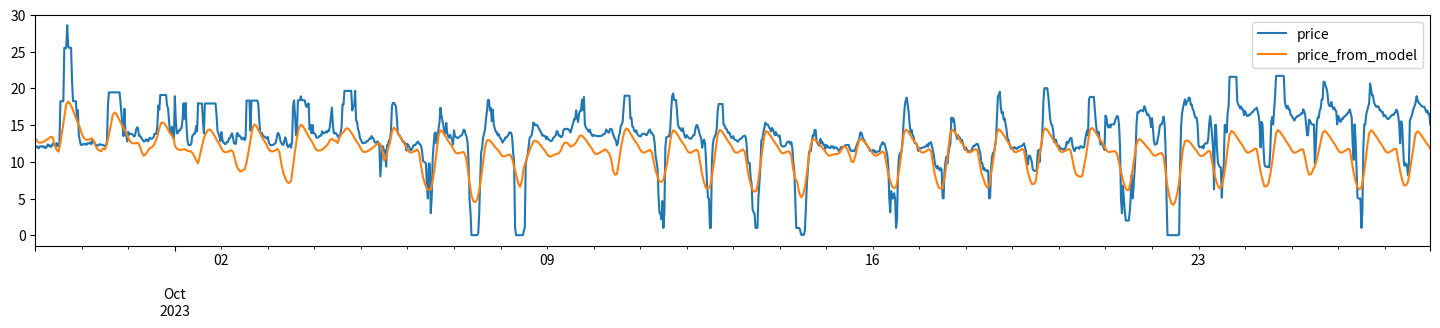

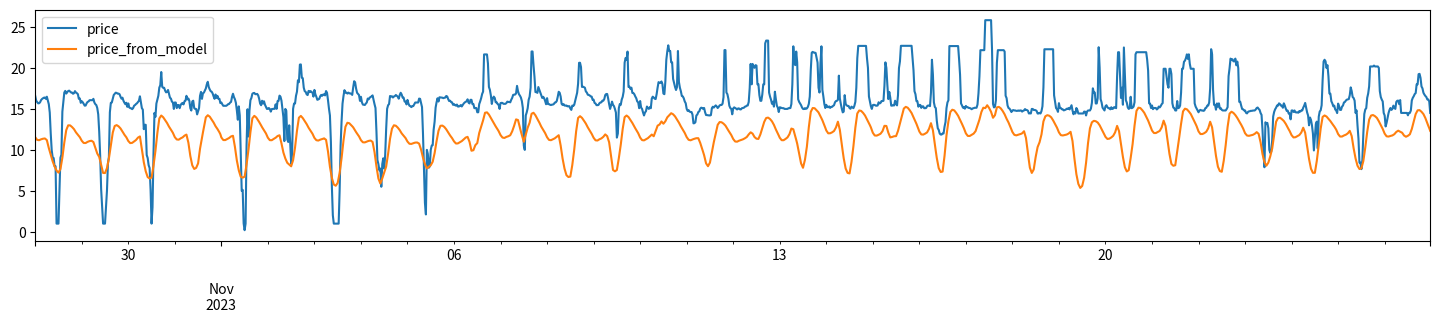

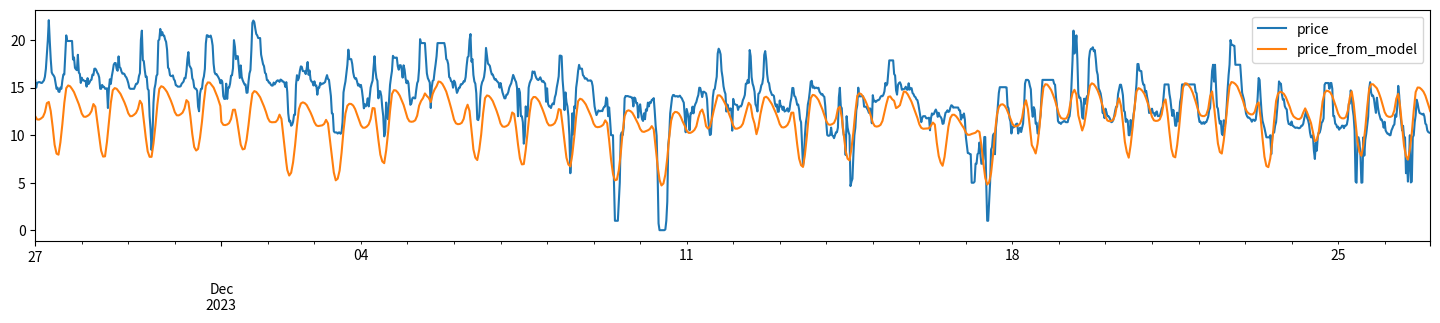

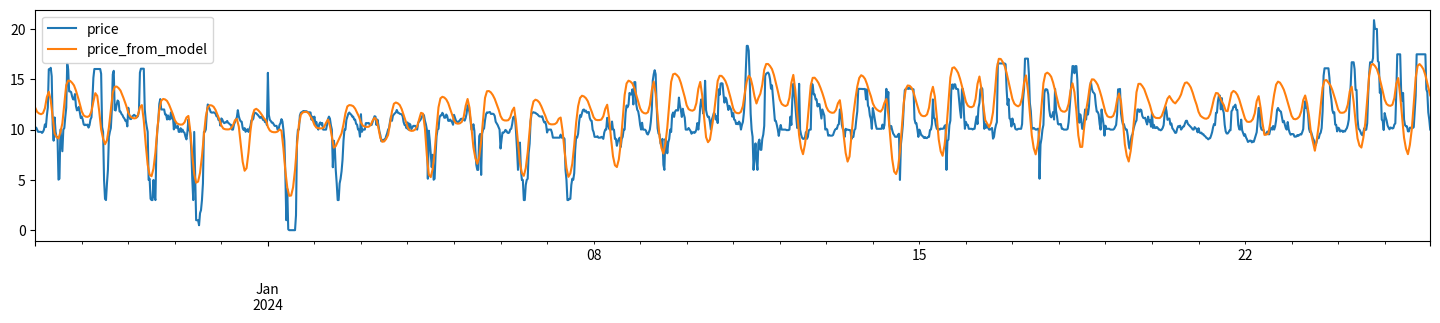

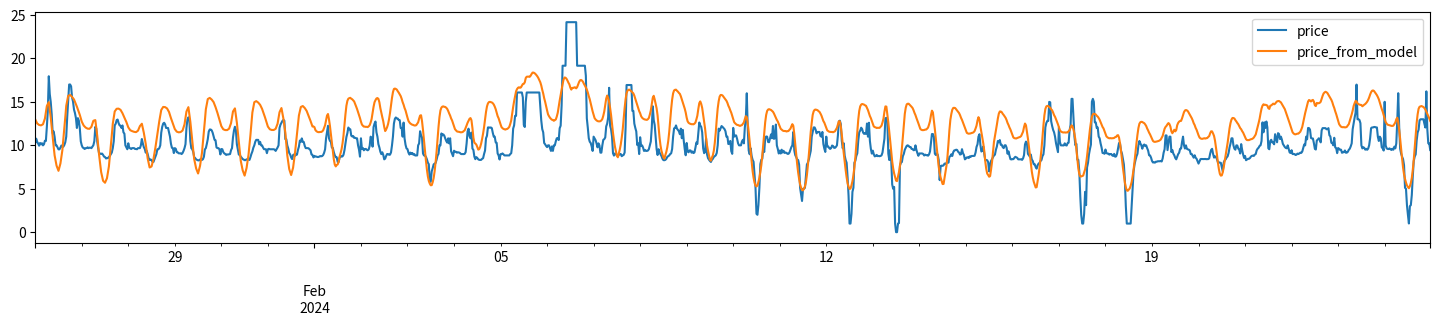

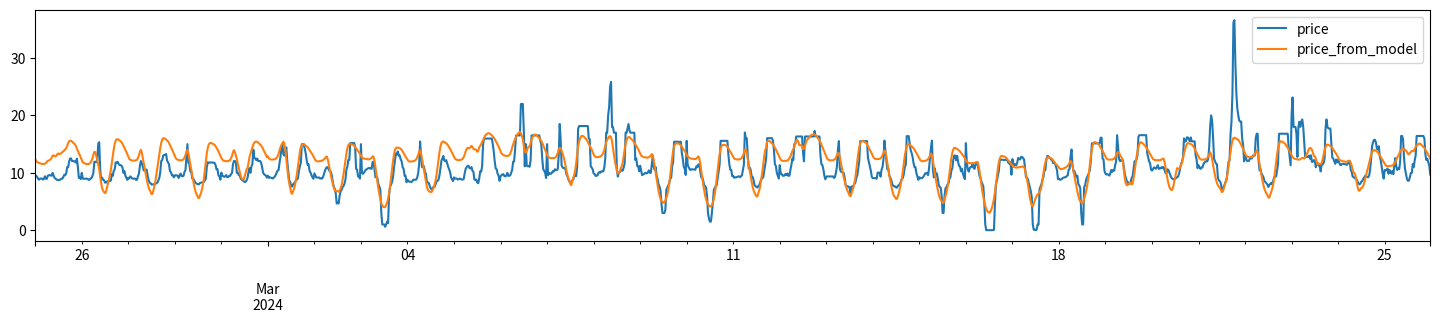

In [84]:
for i in range(12):
  df_all[48*30*i:48*30*(i+1)].plot(y=["price", "price_from_model"], figsize=(18, 3))
# df_all[:48*30].plot(y=["price", "price_from_model"], figsize=(18, 3))
# df_all[48*30:48*61].plot(y=["price", "price_from_model"], figsize=(18, 3))

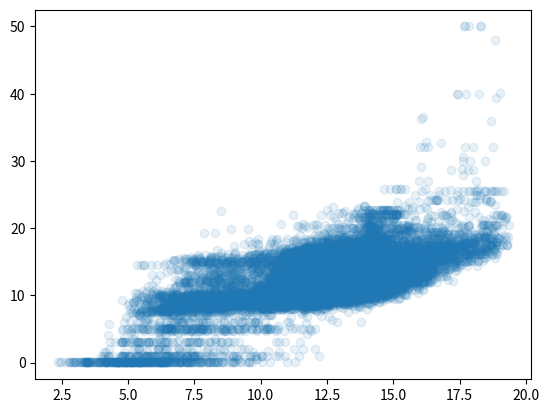

In [51]:
# 散布図
plt.scatter(df_all["price_from_model"], df_all["price"], alpha=0.1)


<Axes: >

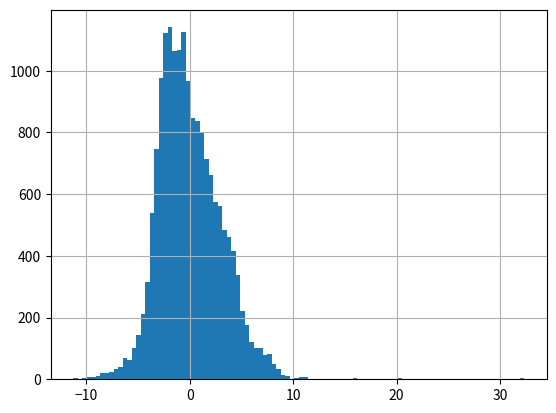

In [52]:
# 残渣の分布
result.resid.hist(bins=100)

In [55]:
# モデルの入力のばらつきはいったん無視し、予測値の残差がランダムに発生すると仮定して、モンテカルロシミュレーションを行いたいと考えています。
# 一方残差の周期成分（月全体として高めにずれる、1日全体として高めにずれる、30分コマ単位でずれる）を考慮したいです。どのような実装がよいでしょうか。

residuals = df_all["price"] - df_all["price_from_model"]
residuals

2023-04-01 00:00:00    3.237243
2023-04-01 00:30:00    2.684374
2023-04-01 01:00:00    0.661505
2023-04-01 01:30:00   -0.081043
2023-04-01 02:00:00   -0.133590
                         ...   
2024-03-31 21:30:00    0.926035
2024-03-31 22:00:00    0.845497
2024-03-31 22:30:00   -1.500946
2024-03-31 23:00:00   -1.422272
2024-03-31 23:30:00   -1.716711
Freq: 30min, Length: 17568, dtype: float64

In [86]:
# 残差は明らかに自己相関をもつので、ARモデルでモデル化する
# ref: https://jp.mathworks.com/help/econ/monte-carlo-simulation-of-regression-models-with-arima-errors.html
# ref: https://jp.mathworks.com/help/econ/simulate-an-arma-error-model.html
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(residuals, lags=48, trend="n")
ar_model = model.fit()
ar_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                17568
Model:                    AutoReg(48)   Log Likelihood              -26479.592
Method:               Conditional MLE   S.D. of innovations              1.097
Date:                Fri, 11 Oct 2024   AIC                          53057.185
Time:                        23:54:06   BIC                          53437.969
Sample:                    04-02-2023   HQIC                         53182.569
                         - 03-31-2024                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.9232      0.008    122.323      0.000       0.908       0.938
y.L2          -0.0859      0.010     -8.362      0.000      -0.106      -0.066
y.L3          -0.0106      0.010     -1.032      0.302      -0.031       0.010
y.L4           0.0309      0.010      3.003      0.003       0.011       0.051
y.L5          -0.0318      0.010     -3.089      0.002      -0.052      -0.012
y.L6           0.0003      0.010      0.029      0.977      -0.020       0.020
y.L7           0.0276      0.010      2.677      0.007       0.007       0.048
y.L8          -0.0233      0.010     -2.263      0.024      -0.043      -0.003
y.L9           0.0037      0.010      0.364      0.716      -0.016       0.024
y.L10         -0.0045      0.010     -0.440      0.660      -0.025       0.016
y.L11          0.0008      0.010      0.076      0.939      -0.019       0.021
y.L12         -0.0100      0.010     -0.972      0.331      -0.030       0.010
y.L13          0.0407      0.010      3.953      0.000       0.021       0.061
y.L14         -0.0253      0.010     -2.463      0.014      -0.046      -0.005
y.L15          0.0223      0.010      2.165      0.030       0.002       0.042
y.L16         -0.0232      0.010     -2.257      0.024      -0.043      -0.003
y.L17          0.0037      0.010      0.362      0.717      -0.016       0.024
y.L18          0.0067      0.010      0.647      0.518      -0.014       0.027
y.L19         -0.0037      0.010     -0.360      0.719      -0.024       0.016
y.L20         -0.0074      0.010     -0.718      0.473      -0.028       0.013
y.L21         -0.0098      0.010     -0.949      0.343      -0.030       0.010
y.L22          0.0325      0.010      3.157      0.002       0.012       0.053
y.L23         -0.0160      0.010     -1.559      0.119      -0.036       0.004
y.L24         -0.0069      0.010     -0.675      0.500      -0.027       0.013
y.L25          0.0089      0.010      0.869      0.385      -0.011       0.029
y.L26          0.0187      0.010      1.816      0.069      -0.001       0.039
y.L27         -0.0342      0.010     -3.325      0.001      -0.054      -0.014
y.L28          0.0061      0.010      0.594      0.553      -0.014       0.026
y.L29          0.0122      0.010      1.189      0.234      -0.008       0.032
y.L30         -0.0058      0.010     -0.561      0.575      -0.026       0.014
y.L31          0.0059      0.010      0.577      0.564      -0.014       0.026
y.L32          0.0091      0.010      0.885      0.376      -0.011       0.029
y.L33          0.0092      0.010      0.899      0.369      -0.011       0.029
y.L34         -0.0173      0.010     -1.677      0.094      -0.037       0.003
y.L35          0.0360      0.010      3.496      0.000       0.016       0.056
y.L36         -0.0367      0.010     -3.569      0.000      -0.057      -0.017
y.L37          0.0129      0.010      1.254      0.210      -0.007       0.033
y.L38         -0.0053      0.010     -0.520      0.603      -0.026       0.015
y.

In [87]:
# シミュレーション内でARモデルを使用
num_simulations = 100
for i in range(num_simulations):
    random_shocks = ar_model.simulate(nsimulations=48*365)

AttributeError: 'AutoRegResults' object has no attribute 'simulate'

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 季節分解の実施
decomposition = seasonal_decompose(residuals, model='additive', period=48)  # 1日の期間は48（30分間隔×24時間）

# トレンド、季節成分、ランダム成分の取得
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

In [63]:
from prophet import Prophet

df_prophet = residuals.reset_index()
df_prophet.columns = ['ds', 'y']

In [74]:
model_prophet = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False
)

# # 日次の季節性を追加（1日ごとの周期性）
# model_prophet.add_seasonality(name='daily', period=1, fourier_order=15)

# # 週次の季節性を追加（7日ごとの周期性）
# model_prophet.add_seasonality(name='weekly', period=7, fourier_order=10)

# # 月次の季節性を追加（30日ごとの周期性）
# model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [75]:
model_prophet.fit(df_prophet)

18:24:40 - cmdstanpy - INFO - Chain [1] start processing
18:24:42 - cmdstanpy - INFO - Chain [1] done processing


In [76]:
# 将来のデータフレームの作成（例：1年分の30分間隔）
future = model_prophet.make_future_dataframe(periods=48*365, freq='30min')
forecast = model_prophet.predict(future)

In [78]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-04-01 00:00:00,-0.511654,-4.050004,1.724983,-0.511654,-0.511654,-0.685407,-0.685407,-0.685407,-0.712586,-0.712586,-0.712586,0.027179,0.027179,0.027179,0.0,0.0,0.0,-1.197061
1,2023-04-01 00:30:00,-0.512528,-3.884412,2.024659,-0.512528,-0.512528,-0.628564,-0.628564,-0.628564,-0.651241,-0.651241,-0.651241,0.022678,0.022678,0.022678,0.0,0.0,0.0,-1.141092
2,2023-04-01 01:00:00,-0.513401,-3.953937,1.601902,-0.513401,-0.513401,-0.565007,-0.565007,-0.565007,-0.582871,-0.582871,-0.582871,0.017864,0.017864,0.017864,0.0,0.0,0.0,-1.078408
3,2023-04-01 01:30:00,-0.514275,-3.977774,1.964679,-0.514275,-0.514275,-0.507536,-0.507536,-0.507536,-0.520281,-0.520281,-0.520281,0.012746,0.012746,0.012746,0.0,0.0,0.0,-1.021811
4,2023-04-01 02:00:00,-0.515149,-4.083690,1.806993,-0.515149,-0.515149,-0.464456,-0.464456,-0.464456,-0.471785,-0.471785,-0.471785,0.007328,0.007328,0.007328,0.0,0.0,0.0,-0.979605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35083,2025-03-31 21:30:00,8.393006,-90.798319,115.778841,-91.415440,117.868731,-0.372869,-0.372869,-0.372869,-0.435885,-0.435885,-0.435885,0.063016,0.063016,0.063016,0.0,0.0,0.0,8.020137
35084,2025-03-31 22:00:00,8.393508,-92.552314,117.244968,-91.420619,117.882406,-0.532491,-0.532491,-0.532491,-0.597724,-0.597724,-0.597724,0.065233,0.065233,0.065233,0.0,0.0,0.0,7.861016
35085,2025-03-31 22:30:00,8.394009,-91.867689,116.177097,-91.425799,117.896080,-0.636179,-0.636179,-0.636179,-0.703612,-0.703612,-0.703612,0.067433,0.067433,0.067433,0.0,0.0,0.0,7.757830
35086,2025-03-31 23:00:00,8.394511,-90.776675,117.407489,-91.430978,117.909755,-0.683016,-0.683016,-0.683016,-0.752639,-0.752639,-0.752639,0.069623,0.069623,0.069623,0.0,0.0,0.0,7.711495


In [81]:
# 季節性成分の合計
# seasonal_components = forecast[['ds', 'daily', 'weekly', 'monthly']].set_index('ds')
seasonal_components = forecast[['ds', 'daily', 'weekly', 'trend', 'additive_terms']].set_index('ds')
seasonal_sum = seasonal_components.sum(axis=1)

<Axes: xlabel='ds'>

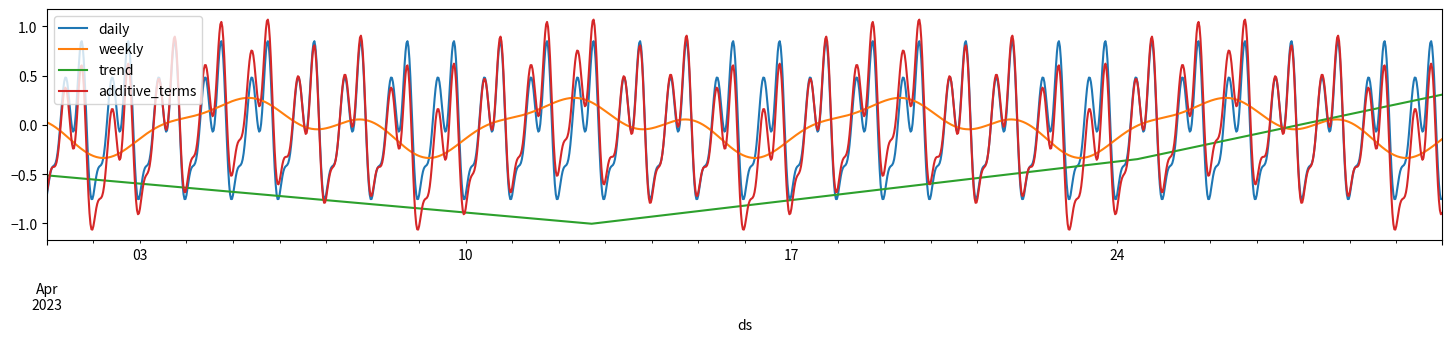

In [83]:
seasonal_components[:48*30].plot(figsize=(18, 3))

### 説明変数と自己相関を同時に考慮したGARCH-Xモデルによるシミュレーションの例

In [25]:
df_all

,エリア需要,太陽光発電実績,price,LNG_CIF
2023-04-01 00:00:00,23380.0,0.0,14.68,93.159577
2023-04-01 00:30:00,22920.0,0.0,13.99,93.159577
2023-04-01 01:00:00,22460.0,0.0,11.83,93.159577
2023-04-01 01:30:00,22435.0,0.0,11.08,93.159577
2023-04-01 02:00:00,22410.0,0.0,11.02,93.159577
...,...,...,...,...
2024-03-31 21:30:00,24806.0,0.0,12.35,95.969438
2024-03-31 22:00:00,24204.0,0.0,12.09,95.969438
2024-03-31 22:30:00,23387.0,0.0,9.50,95.969438
2024-03-31 23:00:00,23056.0,0.0,9.48,95.969438


In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# サンプルデータの生成（実際には実データを使用してください）
np.random.seed(42)
dates = df_all.index
price = df_all["price"]
demand = df_all["エリア需要"]
solar = df_all["太陽光発電実績"]
data = pd.DataFrame({'Price': price, 'Demand': demand, 'Solar': solar}, index=dates)

# 外生変数の作成
data['Hour'] = data.index.hour
data['Weekday'] = data.index.weekday
data['Is_Weekend'] = data['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
data['Is_Daytime'] = data['Hour'].apply(lambda x: 1 if 8 <= x <= 18 else 0)

# ダミー変数の作成
exog_vars = ['Demand', 'Solar', 'Is_Weekend', 'Is_Daytime']
exog = data[exog_vars]

# 平均方程式のモデル化
# 外生変数を含むGARCHモデルの定義
model = arch_model(data['Price'], x=exog, mean='ARX', vol='GARCH', p=1, q=1, dist='normal', lags=[1,48,48*7])

# モデルのフィッティング
res = model.fit(update_freq=0)
print(res.summary())


Optimization terminated successfully    (Exit mode 0)
            Current function value: 24017.636217483603
            Iterations: 50
            Function evaluations: 694
            Gradient evaluations: 50
                          AR-X - GARCH Model Results                          
Dep. Variable:                  Price   R-squared:                       0.914
Mean Model:                      AR-X   Adj. R-squared:                  0.914
Vol Model:                      GARCH   Log-Likelihood:               -24017.6
Distribution:                  Normal   AIC:                           48057.3
Method:            Maximum Likelihood   BIC:                           48142.6
                                        No. Observations:                17232
Date:                Sat, Oct 12 2024   Df Residuals:                    17224
Time:                        05:36:01   Df Model:                            8
                                   Mean Model                                 

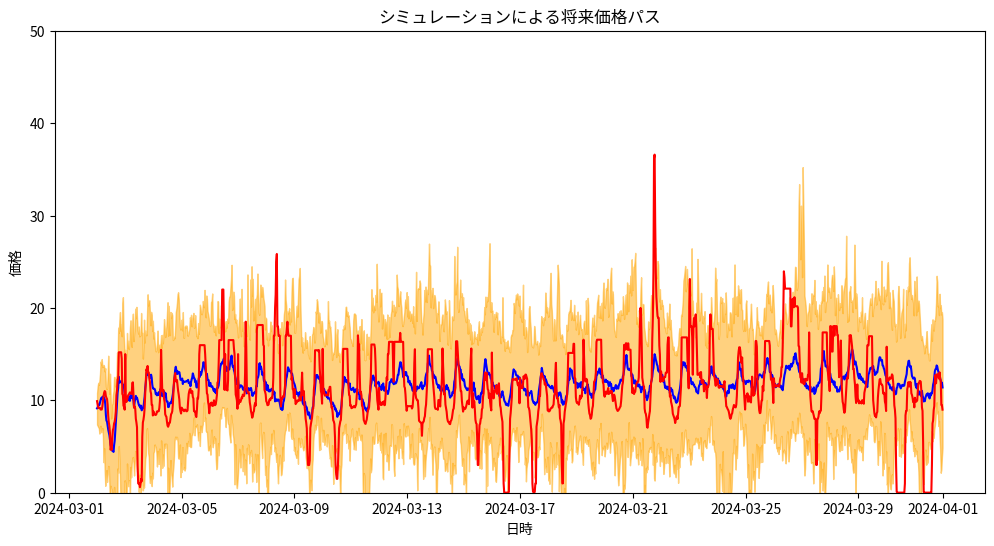

In [95]:
# 将来の外生変数を作成（例として最後の1か月分のデータを使用）
future_exog = exog.tail(48*30)

# 将来パスのシミュレーション
n_simulations = 100  # シミュレーションの回数
steps = len(future_exog)  # 予測期間
simulated_paths = np.zeros((n_simulations, steps))

sim_res = res.forecast(simulations=n_simulations, horizon=steps, x=future_exog.values[:, np.newaxis, :].T, method='simulation')

# シミュレーション結果の取得
simulated_values = sim_res.simulations.values  # 形状: (horizon, simulations_per_forecast, number of forecasts)

# シミュレーションパスの整形
simulated_paths = simulated_values[0, :, :]  # 形状: (simulations, steps)

# 各時間ステップごとに95%信頼区間を計算
lower_quantile = np.percentile(simulated_paths, 2.5, axis=0)
upper_quantile = np.percentile(simulated_paths, 97.5, axis=0)
median = np.percentile(simulated_paths, 50, axis=0)

# 結果のプロット
plt.figure(figsize=(12, 6))
# for i in range(n_simulations):
    # plt.plot(future_exog.index, simulated_paths[i], color='blue', alpha=0.1)

# 95%信頼区間を塗りつぶしで表示
plt.fill_between(future_exog.index, lower_quantile, upper_quantile, color='orange', alpha=0.5, label='95%信頼区間')

# シミュレーションの中央値をプロット
plt.plot(future_exog.index, median, color='blue', label='中央値')

# 実際の価格（例として過去の価格を使用）をプロット
plt.plot(future_exog.index, data['Price'].tail(len(future_exog)), color='red', label='実際の価格')

plt.title('シミュレーションによる将来価格パス')
plt.ylim(0, 50)
plt.xlabel('日時')
plt.ylabel('価格')
plt.show()


In [83]:
# 各時間ステップごとに95%信頼区間を計算
lower_quantile = np.percentile(simulated_paths, 2.5, axis=0)
upper_quantile = np.percentile(simulated_paths, 97.5, axis=0)
median = np.percentile(simulated_paths, 50, axis=0)


In [84]:
lower_quantile

array([7.27842367, 6.5667605 , 6.52739798, ..., 3.87728366, 3.04498634,
       3.67464312])

In [85]:
upper_quantile

array([11.12242393, 12.17222811, 12.9146067 , ..., 19.9215981 ,
       19.5370987 , 18.99105427])